In [29]:
import numpy
import pandas
import pandas as pd
import csv
import os
import networkx as nx


In [30]:
tr_path = 'C:/Users/Administrator/Desktop/台科/課程/112-2 社群分析/112-2 Social Media Analytics/hw1 Linkprediction/2024-ntust-practice-of-social-media-analytics-hw1/train.csv'  # path to training data
train_df = pd.read_csv(tr_path)

tt_path = 'C:/Users/Administrator/Desktop/台科/課程/112-2 社群分析/112-2 Social Media Analytics/hw1 Linkprediction/2024-ntust-practice-of-social-media-analytics-hw1/test.csv'   # path to testing data
test_df = pd.read_csv(tt_path)

In [31]:
!nvidia-smi

Fri May  3 23:41:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.92                 Driver Version: 545.92       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P8              18W / 170W |   1499MiB / 12288MiB |     21%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [32]:
train_df

,node1,node2,label
0,29237,16563,1
1,32869,24548,0
2,48837,17831,1
3,31387,44509,0
4,15102,10271,1
...,...,...,...
31995,51510,44952,1
31996,30089,48199,0
31997,1418,13815,0
31998,5451,24600,1


In [33]:
test_df

,idx,node1,node2
0,0,5416,45023
1,1,6681,40749
2,2,44162,40953
3,3,51387,51233
4,4,6498,24093
...,...,...,...
7995,7995,15213,5972
7996,7996,30870,8448
7997,7997,5409,49118
7998,7998,14298,45426


In [34]:
x = train_df.drop(['label'], axis = 1)
x

,node1,node2
0,29237,16563
1,32869,24548
2,48837,17831
3,31387,44509
4,15102,10271
...,...,...
31995,51510,44952
31996,30089,48199
31997,1418,13815
31998,5451,24600


In [38]:
#split train dev dataset
from sklearn.model_selection import train_test_split


y = train_df['label']
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state = 0)
#X_train, X_dev, y_train, y_dev = train_test_split(X, y,test_size=0.2,random_state=0)
# Check if a random node from the test set is in the graph

In [41]:
# Create a directed graph from your training data
G = nx.from_pandas_edgelist(train_df[train_df['label'] == 1], "node1", "node2", create_using=nx.DiGraph())
def directed_jaccard_coefficient(G, node1, node2):
    if G.has_node(node1) and G.has_node(node2):
        successors1 = set(G.successors(node1))
        successors2 = set(G.successors(node2))
        intersection = len(successors1.intersection(successors2))
        union = len(successors1.union(successors2))
        return intersection / union if union > 0 else 0
    return 0

def directed_resource_allocation_index(G, node1, node2):
    if G.has_node(node1) and G.has_node(node2):
        common_successors = set(G.successors(node1)).intersection(set(G.successors(node2)))
        ra_index = sum(1 / G.in_degree(n) for n in common_successors if G.in_degree(n) > 0)
        return ra_index
    return 0

def count_successors(G, node):
    if G.has_node(node):
        return len(list(G.successors(node)))
    return 0

def count_predecessors(G, node):
    if G.has_node(node):
        return len(list(G.predecessors(node)))
    return 0

# Apply the metrics to your dataframe
train_df['directed_jaccard'] = train_df.apply(lambda row: directed_jaccard_coefficient(G, row['node1'], row['node2']), axis=1)
train_df['dir_resource_alloc'] = train_df.apply(lambda row: directed_resource_allocation_index(G, row['node1'], row['node2']), axis=1)
train_df['successor_count'] = train_df['node1'].apply(lambda x: count_successors(G, x))
train_df['predecessor_count'] = train_df['node2'].apply(lambda x: count_predecessors(G, x))

# Similarly apply the metrics to the test dataframe
test_df['directed_jaccard'] = test_df.apply(lambda row: directed_jaccard_coefficient(G, row['node1'], row['node2']), axis=1)
test_df['dir_resource_alloc'] = test_df.apply(lambda row: directed_resource_allocation_index(G, row['node1'], row['node2']), axis=1)
test_df['successor_count'] = test_df['node1'].apply(lambda x: count_successors(G, x))
test_df['predecessor_count'] = test_df['node2'].apply(lambda x: count_predecessors(G, x))

# print(train_df['common_neighbors'].describe())  # This will give you a summary of the feature
# print(test_df['jaccard_coefficient'].describe())  # This will give you a summary of the feature
# print(test_df['resource_allocation_index'].describe())  # This will give you a summary of the feature


In [42]:
x_test = test_df.drop(['idx'], axis = 1)
x_test

,node1,node2,directed_jaccard,dir_resource_alloc,successor_count,predecessor_count
0,5416,45023,0.0,0.0,18,8
1,6681,40749,0.0,0.0,0,0
2,44162,40953,0.0,0.0,0,1
3,51387,51233,0.0,0.0,4,13
4,6498,24093,0.0,0.0,2,1
...,...,...,...,...,...,...
7995,15213,5972,0.0,0.0,0,0
7996,30870,8448,0.0,0.0,0,0
7997,5409,49118,0.0,0.0,0,0
7998,14298,45426,0.0,0.0,0,0


## xgboost

In [43]:
from xgboost import XGBClassifier

# 建立 XGBClassifier 模型
xgboostModel = XGBClassifier(n_estimators=180, learning_rate= 0.03)
# 使用訓練資料訓練模型
xgboostModel.fit(train_df.drop(['label'], axis = 1),train_df['label'])
# 使用訓練資料預測分類
predictions_xgboost = xgboostModel.predict(x_test)

In [44]:
len(predictions_xgboost)

8000

In [45]:
predictions_xgboost = predictions_xgboost.tolist()

In [46]:
submission_df = pd.read_csv('C:/Users/Administrator/Desktop/台科/課程/112-2 社群分析/112-2 Social Media Analytics/hw1 Linkprediction/2024-ntust-practice-of-social-media-analytics-hw1/sample_submission.csv')
submission_xgboost = pd.DataFrame({ 'idx': submission_df.idx.values, 'ans': predictions_xgboost })
submission_xgboost.to_csv("submission_xgboost.csv", index=False)

#### 0.80553

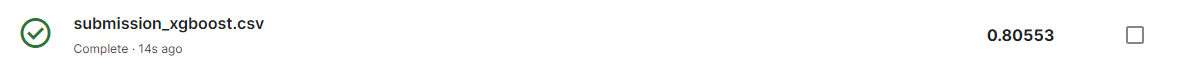